In [30]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from rockphypy import EM
from publib import set_style

# Read the Excel file
df = pd.read_excel('Wallula.xlsx', sheet_name='Filtered_Data_HS')
K_log_sat = df["K_log"]
G_log = df["G_log"]

Km = 80.72  # Bulk modulus of the matrix
mum = 41.51  # Shear modulus of the matrix
Kf = 2.1 # Bulk modulus of brine
Ki = 0  # Bulk modulus of inclusions
mui = 0  # Shear modulus of inclusions

# Aspect ratios to loop through
aspect_ratios = [0.15, 0.25, 0.35]

# Define the function for zeta_m
def zeta_m(Km, mum):
    return mum * (9 * Km + 8 * mum) / (6 * (Km + 2 * mum))

# Define the system of equations to solve
def equations(vars, x1, Pmi, Qmi):
    Keff, mueff = vars
    eq1 = (Keff - Km) - ((Keff + (4 * mum) / 3) / (Km + (4 * mum) / 3)) * x1 * (Ki - Km) * Pmi
    eq2 = (mueff - mum) - ((mueff + zeta_m(Km, mum)) / (mum + zeta_m(Km, mum))) * x1 * (mui - mum) * Qmi
    return [eq1, eq2]

# Create dictionaries to store results for each aspect ratio
results = {ar: {"Keff": [], "mueff": []} for ar in aspect_ratios}

# Loop through each aspect ratio
for aspect_ratio in aspect_ratios:
    Pmi, Qmi = EM.PQ(Km, mum, Ki, mui, aspect_ratio)
    
    initial_guess = [Km, mum]
    
    # Loop through each phi value to calculate the effective moduli
    for phi in df["Phi"]:
        x1 = phi  # Volume fraction of inclusions, corresponding to porosity phi
        Kef, mueff = fsolve(equations, initial_guess, args=(x1, Pmi, Qmi))
        #Gassmann's equation to find saturated bulk moduli of rock
        A1 = 1 - (Kef/ Km)
        Keff = Kef + (A1 * A1) / ((phi / Kf) + ((1 - phi) / Km) - (Kef / (Km * Km)))

        results[aspect_ratio]["Keff"].append(Keff)
        results[aspect_ratio]["mueff"].append(mueff)

# Convert lists to numpy arrays for easier plotting and manipulation
for ar in aspect_ratios:
    results[ar]["Keff"] = np.array(results[ar]["Keff"])
    results[ar]["mueff"] = np.array(results[ar]["mueff"])


Keff_values_015 = results[0.15]["Keff"]
mueff_values_015 = results[0.15]["mueff"]

Keff_values_025 = results[0.25]["Keff"]
mueff_values_025 = results[0.25]["mueff"]

Keff_values_035 = results[0.35]["Keff"]
mueff_values_035 = results[0.35]["mueff"]


In [31]:
#SCA
Km1 = [80.72, 0]  # Bulk modulus of the matrix and inclusion
Gm1 = [41.51, 0]  # Shear modulus of the matrix and inclusion

# Initialize dictionaries to store results for each aspect ratio
results_SCA = {ar: {"Keff": [], "Geff": []} for ar in aspect_ratios}

# Iterate over each aspect ratio
for ar in aspect_ratios:
    a = [1, ar]  # Define the aspect ratio for this iteration
    
    # Iterate over each row in the DataFrame
    for index, row in df.iterrows():
        Phi = row["Phi"]
        
        # Calculate x for this row
        x = [1 - Phi, Phi]
        
        Keff, Geff = EM.Berryman_sc(Km1, Gm1, x, a)
        
        # Calculate saturated bulk modulus using Gassmann's equation
        A1 = 1 - (Keff / Km1[0])
        K_Sat = Keff + (A1 * A1) / ((Phi / 2.1) + ((1 - Phi) / Km1[0]) - (Keff / (Km1[0] ** 2)))
        
        # Append calculated Keff and Geff to the lists
        results_SCA[ar]["Keff"].append(K_Sat)
        results_SCA[ar]["Geff"].append(Geff)

# Convert results to numpy arrays
for ar in aspect_ratios:
    results_SCA[ar]["Keff"] = np.array(results_SCA[ar]["Keff"])
    results_SCA[ar]["Geff"] = np.array(results_SCA[ar]["Geff"])

Keff_SCA_015 = results_SCA[0.15]["Keff"]
Geff_SCA_015 = results_SCA[0.15]["Geff"]

Keff_SCA_025 = results_SCA[0.25]["Keff"]
Geff_SCA_025 = results_SCA[0.25]["Geff"]

Keff_SCA_035 = results_SCA[0.35]["Keff"]
Geff_SCA_035 = results_SCA[0.35]["Geff"]


C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\rockphypy\EM.py:517: RuntimeWarning: overflow encountered in multiply
  Tijij = Tiijj/3 + 2/F3 + 1/F4 + (F4*F5 + F6*F7 - F8*F9)/(F2*F4)
C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\rockphypy\EM.py:507: RuntimeWarning: overflow encountered in multiply
  F2 = 1.0 + A*(1.0 + 1.5*(f + theta) - R*(1.5*f + 2.5*theta)) + B*(3.0 - 4.0*R) + A*(A + 3.0*B)*(1.5 - 2.0*R)*(f + theta - R*(f - theta +
C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\rockphypy\EM.py:517: RuntimeWarning: invalid value encountered in divide
  Tijij = Tiijj/3 + 2/F3 + 1/F4 + (F4*F5 + F6*F7 - F8*F9)/(F2*F4)
C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache

In [32]:
# DEM
Gm = 41.50923084095074 # Shear modulus of the matrix
Km = 80.7167139034238 # Bulk modulus of the matrix
GR =    df['GR']
RHOB = df['RHOB']
Phi = df['Phi']
Sw = df['SW']
DEP = df['DEPTH']
Vp = df['VP']
Vs = df['VS']
K_log_sat = df['K_log']
G_log = df['G_log']

def alphafun(alp, Kmat_1, Gmat_1, Phi, Kfl_2):
    thet = np.minimum(alp, 0.99) * (np.arccos(np.minimum(alp, 0.99)) - (np.minimum(alp, 0.99) * np.sqrt(1 - (np.minimum(alp, 0.99) * np.minimum(alp, 0.99))))) / (((1 - np.minimum(alp, 0.99) * np.minimum(alp, 0.99))) ** 1.5)
    g1 = (alp * alp) * (3*thet - 2) / (1 - alp * alp)
    s01 = (2 - 3 * g1 - 3 * thet) / (4 * thet - 4 * g1 - 6 * thet * thet)
    s11 = (thet - g1) / (2 - 3 * g1 - 3 * thet)
    s21 = 4/3
    s31 = 2 * (thet - g1) / (3*(2 * thet - 2 * g1 - 3 * thet * thet))

    #Coeefficients
    f= np.minimum(alp, 0.99)**2*(3.0*thet - 2.0)/(1.0 - np.minimum(alp, 0.99)**2)
    A = Gi/Gmat_1 - 1.0
    B = (Ki/Kmat_1 - Gi/Gmat_1)/3.0
    R = Gmat_1/(Kmat_1 + (4.0/3.0)*Gmat_1) # 
    F1 = 1.0 + A*(1.5*(f + thet) - R*(1.5*f + 2.5*thet - 4.0/3.0))
    F2 = 1.0 + A*(1.0 + 1.5*(f + thet) - R*(1.5*f + 2.5*thet)) + B*(3.0 - 4.0*R) + A*(A + 3.0*B)*(1.5 - 2.0*R)*(f + thet - R*(f - thet + 2.0*thet**2))
    F3 = 1.0 + A*(1.0 - f - 1.5*thet + R*(f + thet))
    F4 = 1.0 + (A/4.0)*(f + 3.0*thet - R*(f - thet))
    F5 = A*(-f + R*(f + thet - 4.0/3.0)) + B*thet*(3.0 - 4.0*R)
    F6 = 1.0 + A*(1.0 + f - R*(f + thet)) + B*(1.0 - thet)*(3.0 - 4.0*R)
    F7 = 2.0 + (A/4.0)*(3.0*f + 9.0*thet - R*(3.0*f + 5.0*thet)) + B*thet*(3.0 - 4.0*R)
    F8 = A*(1.0 - 2.0*R + (f/2.0)*(R - 1.0) + (thet/2.0)*(5.0*R - 3.0)) + B*(1.0 - thet)*(3.0 - 4.0*R)
    F9 = A*((R - 1.0)*f - R*thet) + B*thet*(3.0 - 4.0*R)
    Tiijj = 3*F1/F2
    Tijij = Tiijj/3 + 2/F3 + 1/F4 + (F4*F5 + F6*F7 - F8*F9)/(F2*F4)
    P = Tiijj/3
    Q = (Tijij - P)/5


    R_ = -R**2

    F1_ = -A*(( 3* f/2) + (5* thet / 2) - 4 / 3) * R**2
    F2_ = ((-A/2)*(3*f+5*thet) - 4*B + ((A*(A+3*B)/2)) * (-7*f - thet - 6*thet*thet + 8*R*(f-thet + 2*thet*thet)))*R_
    F3_ = (A/2) * ((2 - thet *((1 + alp**2)*f)/ alp**2) * R_)
    F4_ = ((-A / 4) * (f - thet) * R_)
    F5_ = (A * (f+thet-(4/3))-4*B*thet)*R_
    F6_ = (-A*(f+thet) - 4*B*(1- thet))*R_
    F7_ = ((-A/4)*(5*thet+3*f) - 4*B*thet)*R_
    F8_ = (A*(-2+(f/2)+(2.5*thet)) -4*B*(1-thet))*R_
    F9_ = (A*(f-thet) - 4*B*thet)*R_

    # Calculations for T_iijj and T_ijij
    T_iijj_ = (3*(F1_*F2 - F1*F2_))/(2*F2*F2)
    T_ijij_ = ((F1_*F2-F1*F2_)/(F2**2 ))-(2*F3_)/(F3**2) - (F4_)/(F4**2)  + ((F4_*F5 + F4 * F5_ + F6_*F7 + F6*F7_ - F8_* F9 - F8*F9_)*F2*F4 - (F4*F5 + F6*F7 - F8*F9 )*(F2_*F4 + F2*F4_))/(F2*F2*F4*F4 )

    # Calculation for P and Q
    b = (6*T_iijj_)/15 - T_ijij_/5
    a = (P-Q)-(b*Kmat_1)/Gmat_1 
    K_Dry_DEM_Inverted = Kmat_1 * ((1 - Phi) ** (
            s01 * (s11 + s21 - s31 + (s11 - s31) * (s21 - s31) / (s31 + (Kmat_1 / Gmat_1))))) / (
                     1 + ((b*Kmat_1)/(a*Gmat_1) - (b*Kmat_1*((1-Phi)**a))/(a*Gmat_1)))**(s01/b)
    G_Dry_DEM_Inverted = Gmat_1 * ((1 - Phi) ** (
            (s01 * (s11 + s21 - s31 + (s11 - s31) * (s21 - s31) / (s31 + (Kmat_1 / Gmat_1)))) + 1.1)) / (
                     1 + ((b*Kmat_1)/(a*Gmat_1) - (b*Kmat_1*((1-Phi)**a))/(a*Gmat_1)))**((s01/b) - 1)
    A1 = 1 - (K_Dry_DEM_Inverted / Kmat_1)
    A = (A1 * A1) / ((Phi / Kfl_2) + ((1 - Phi) / Kmat_1) - (K_Dry_DEM_Inverted /( Kmat_1 * Kmat_1)))
    K_Sat_DEM_Inverted = K_Dry_DEM_Inverted + A
    return K_Sat_DEM_Inverted, G_Dry_DEM_Inverted, K_Dry_DEM_Inverted

def alphafun1(alp, Kmat_1, Gmat_1, Phi, Kfl_2):
    thet = np.minimum(alp, 0.99) * (np.arccos(np.minimum(alp, 0.99)) - (np.minimum(alp, 0.99) * np.sqrt(1 - (np.minimum(alp, 0.99) * np.minimum(alp, 0.99))))) / (((1 - np.minimum(alp, 0.99) * np.minimum(alp, 0.99))) ** 1.5)
    g1 = (alp * alp) * (3*thet - 2) / (1 - alp * alp)
    s01 = (2 - 3 * g1 - 3 * thet) / (4 * thet - 4 * g1 - 6 * thet * thet)
    s11 = (thet - g1) / (2 - 3 * g1 - 3 * thet)
    s21 = 4/3
    s31 = 2 * (thet - g1) / (3*(2 * thet - 2 * g1 - 3 * thet * thet))

    #Coeefficients
    f= np.minimum(alp, 0.99)**2*(3.0*thet - 2.0)/(1.0 - np.minimum(alp, 0.99)**2)
    A = Gi/Gmat_1 - 1.0
    B = (Ki/Kmat_1 - Gi/Gmat_1)/3.0
    R = Gmat_1/(Kmat_1 + (4.0/3.0)*Gmat_1) # 
    F1 = 1.0 + A*(1.5*(f + thet) - R*(1.5*f + 2.5*thet - 4.0/3.0))
    F2 = 1.0 + A*(1.0 + 1.5*(f + thet) - R*(1.5*f + 2.5*thet)) + B*(3.0 - 4.0*R) + A*(A + 3.0*B)*(1.5 - 2.0*R)*(f + thet - R*(f - thet + 2.0*thet**2))
    F3 = 1.0 + A*(1.0 - f - 1.5*thet + R*(f + thet))
    F4 = 1.0 + (A/4.0)*(f + 3.0*thet - R*(f - thet))
    F5 = A*(-f + R*(f + thet - 4.0/3.0)) + B*thet*(3.0 - 4.0*R)
    F6 = 1.0 + A*(1.0 + f - R*(f + thet)) + B*(1.0 - thet)*(3.0 - 4.0*R)
    F7 = 2.0 + (A/4.0)*(3.0*f + 9.0*thet - R*(3.0*f + 5.0*thet)) + B*thet*(3.0 - 4.0*R)
    F8 = A*(1.0 - 2.0*R + (f/2.0)*(R - 1.0) + (thet/2.0)*(5.0*R - 3.0)) + B*(1.0 - thet)*(3.0 - 4.0*R)
    F9 = A*((R - 1.0)*f - R*thet) + B*thet*(3.0 - 4.0*R)
    Tiijj = 3*F1/F2
    Tijij = Tiijj/3 + 2/F3 + 1/F4 + (F4*F5 + F6*F7 - F8*F9)/(F2*F4)
    P = Tiijj/3
    Q = (Tijij - P)/5


    R_ = -R**2

    F1_ = -A*(( 3* f/2) + (5* thet / 2) - 4 / 3) * R**2
    F2_ = ((-A/2)*(3*f+5*thet) - 4*B + ((A*(A+3*B)/2)) * (-7*f - thet - 6*thet*thet + 8*R*(f-thet + 2*thet*thet)))*R_
    F3_ = (A/2) * ((2 - thet *((1 + alp**2)*f)/ alp**2) * R_)
    F4_ = ((-A / 4) * (f - thet) * R_)
    F5_ = (A * (f+thet-(4/3))-4*B*thet)*R_
    F6_ = (-A*(f+thet) - 4*B*(1- thet))*R_
    F7_ = ((-A/4)*(5*thet+3*f) - 4*B*thet)*R_
    F8_ = (A*(-2+(f/2)+(2.5*thet)) -4*B*(1-thet))*R_
    F9_ = (A*(f-thet) - 4*B*thet)*R_

    # Calculations for T_iijj and T_ijij
    T_iijj_ = (3*(F1_*F2 - F1*F2_))/(2*F2*F2)
    T_ijij_ = ((F1_*F2-F1*F2_)/(F2**2 ))-(2*F3_)/(F3**2) - (F4_)/(F4**2)  + ((F4_*F5 + F4 * F5_ + F6_*F7 + F6*F7_ - F8_* F9 - F8*F9_)*F2*F4 - (F4*F5 + F6*F7 - F8*F9 )*(F2_*F4 + F2*F4_))/(F2*F2*F4*F4 )

    # Calculation for P and Q
    b = (6*T_iijj_)/15 - T_ijij_/5
    a = (P-Q)-(b*Kmat_1)/Gmat_1 
    K_Dry_DEM_Inverted = Kmat_1 * ((1 - Phi) ** (
            s01 * (s11 + s21 - s31 + (s11 - s31) * (s21 - s31) / (s31 + (Kmat_1 / Gmat_1))))) / (
                     1 + ((b*Kmat_1)/(a*Gmat_1) - (b*Kmat_1*((1-Phi)**a))/(a*Gmat_1)))**(s01/b)
    G_Dry_DEM_Inverted = Gmat_1 * ((1 - Phi) ** (
            (s01 * (s11 + s21 - s31 + (s11 - s31) * (s21 - s31) / (s31 + (Kmat_1 / Gmat_1)))) + 1.1)) / (
                     1 + ((b*Kmat_1)/(a*Gmat_1) - (b*Kmat_1*((1-Phi)**a))/(a*Gmat_1)))**((s01/b) - 1)
    A1 = 1 - (K_Dry_DEM_Inverted / Kmat_1)
    A = (A1 * A1) / ((Phi / Kfl_2) + ((1 - Phi) / Kmat_1) - (K_Dry_DEM_Inverted /( Kmat_1 * Kmat_1)))
    K_Sat_DEM_Inverted = K_Dry_DEM_Inverted + A
    return K_Sat_DEM_Inverted

def alphafun2(alp, Kmat_1, Gmat_1, Phi, Kfl_2):
    thet = np.minimum(alp, 0.99) * (np.arccos(np.minimum(alp, 0.99)) - (np.minimum(alp, 0.99) * np.sqrt(1 - (np.minimum(alp, 0.99) * np.minimum(alp, 0.99))))) / (((1 - np.minimum(alp, 0.99) * np.minimum(alp, 0.99))) ** 1.5)
    g1 = (alp * alp) * (3*thet - 2) / (1 - alp * alp)
    s01 = (2 - 3 * g1 - 3 * thet) / (4 * thet - 4 * g1 - 6 * thet * thet)
    s11 = (thet - g1) / (2 - 3 * g1 - 3 * thet)
    s21 = 4/3
    s31 = 2 * (thet - g1) / (3*(2 * thet - 2 * g1 - 3 * thet * thet))

    #Coeefficients
    f= np.minimum(alp, 0.99)**2*(3.0*thet - 2.0)/(1.0 - np.minimum(alp, 0.99)**2)
    A = Gi/Gmat_1 - 1.0
    B = (Ki/Kmat_1 - Gi/Gmat_1)/3.0
    R = Gmat_1/(Kmat_1 + (4.0/3.0)*Gmat_1) # 
    F1 = 1.0 + A*(1.5*(f + thet) - R*(1.5*f + 2.5*thet - 4.0/3.0))
    F2 = 1.0 + A*(1.0 + 1.5*(f + thet) - R*(1.5*f + 2.5*thet)) + B*(3.0 - 4.0*R) + A*(A + 3.0*B)*(1.5 - 2.0*R)*(f + thet - R*(f - thet + 2.0*thet**2))
    F3 = 1.0 + A*(1.0 - f - 1.5*thet + R*(f + thet))
    F4 = 1.0 + (A/4.0)*(f + 3.0*thet - R*(f - thet))
    F5 = A*(-f + R*(f + thet - 4.0/3.0)) + B*thet*(3.0 - 4.0*R)
    F6 = 1.0 + A*(1.0 + f - R*(f + thet)) + B*(1.0 - thet)*(3.0 - 4.0*R)
    F7 = 2.0 + (A/4.0)*(3.0*f + 9.0*thet - R*(3.0*f + 5.0*thet)) + B*thet*(3.0 - 4.0*R)
    F8 = A*(1.0 - 2.0*R + (f/2.0)*(R - 1.0) + (thet/2.0)*(5.0*R - 3.0)) + B*(1.0 - thet)*(3.0 - 4.0*R)
    F9 = A*((R - 1.0)*f - R*thet) + B*thet*(3.0 - 4.0*R)
    Tiijj = 3*F1/F2
    Tijij = Tiijj/3 + 2/F3 + 1/F4 + (F4*F5 + F6*F7 - F8*F9)/(F2*F4)
    P = Tiijj/3
    Q = (Tijij - P)/5


    R_ = -R**2

    F1_ = -A*(( 3* f/2) + (5* thet / 2) - 4 / 3) * R**2
    F2_ = ((-A/2)*(3*f+5*thet) - 4*B + ((A*(A+3*B)/2)) * (-7*f - thet - 6*thet*thet + 8*R*(f-thet + 2*thet*thet)))*R_
    F3_ = (A/2) * ((2 - thet *((1 + alp**2)*f)/ alp**2) * R_)
    F4_ = ((-A / 4) * (f - thet) * R_)
    F5_ = (A * (f+thet-(4/3))-4*B*thet)*R_
    F6_ = (-A*(f+thet) - 4*B*(1- thet))*R_
    F7_ = ((-A/4)*(5*thet+3*f) - 4*B*thet)*R_
    F8_ = (A*(-2+(f/2)+(2.5*thet)) -4*B*(1-thet))*R_
    F9_ = (A*(f-thet) - 4*B*thet)*R_

    # Calculations for T_iijj and T_ijij
    T_iijj_ = (3*(F1_*F2 - F1*F2_))/(2*F2*F2)
    T_ijij_ = ((F1_*F2-F1*F2_)/(F2**2 ))-(2*F3_)/(F3**2) - (F4_)/(F4**2)  + ((F4_*F5 + F4 * F5_ + F6_*F7 + F6*F7_ - F8_* F9 - F8*F9_)*F2*F4 - (F4*F5 + F6*F7 - F8*F9 )*(F2_*F4 + F2*F4_))/(F2*F2*F4*F4 )

    # Calculation for P and Q
    b = (6*T_iijj_)/15 - T_ijij_/5
    a = (P-Q)-(b*Kmat_1)/Gmat_1 
    K_Dry_DEM_Inverted = Kmat_1 * ((1 - Phi) ** (
            s01 * (s11 + s21 - s31 + (s11 - s31) * (s21 - s31) / (s31 + (Kmat_1 / Gmat_1))))) / (
                     1 + ((b*Kmat_1)/(a*Gmat_1) - (b*Kmat_1*((1-Phi)**a))/(a*Gmat_1)))**(s01/b)
    G_Dry_DEM_Inverted = Gmat_1 * ((1 - Phi) ** (
            (s01 * (s11 + s21 - s31 + (s11 - s31) * (s21 - s31) / (s31 + (Kmat_1 / Gmat_1)))) + 1.1)) / (
                     1 + ((b*Kmat_1)/(a*Gmat_1) - (b*Kmat_1*((1-Phi)**a))/(a*Gmat_1)))**((s01/b) - 1)
    A1 = 1 - (K_Dry_DEM_Inverted / Kmat_1)
    A = (A1 * A1) / ((Phi / Kfl_2) + ((1 - Phi) / Kmat_1) - (K_Dry_DEM_Inverted /( Kmat_1 * Kmat_1)))
    K_Sat_DEM_Inverted = K_Dry_DEM_Inverted + A
    return G_Dry_DEM_Inverted



In [33]:

Kmat_1 = np.full(len(df), Km)
Gmat_1 = np.full(len(df), Gm)
Kfl_2=np.full(len(df), Kf)# Aspect ratios to loop through
aspect_ratios = [0.15, 0.25, 0.35]

# Initialize dictionaries to store results for each aspect ratio
results_DEM = {ar: {} for ar in aspect_ratios}

# Iterate over each aspect ratio
for ar in aspect_ratios:
    alp = ar  
    
    K_Sat_DEM, G_dry_DEM, K_dry_DEM = alphafun(alp, Kmat_1, Gmat_1, df["Phi"], Kfl_2)
    
    # Store the results in the dictionary
    results_DEM[ar]["K_Sat_DEM"] = K_Sat_DEM
    results_DEM[ar]["G_dry_DEM"] = G_dry_DEM

K_Sat_DEM_015 = results_DEM[0.15]["K_Sat_DEM"]
G_dry_DEM_015 = results_DEM[0.15]["G_dry_DEM"]

K_Sat_DEM_025 = results_DEM[0.25]["K_Sat_DEM"]
G_dry_DEM_025 = results_DEM[0.25]["G_dry_DEM"]

K_Sat_DEM_035 = results_DEM[0.35]["K_Sat_DEM"]
G_dry_DEM_035 = results_DEM[0.35]["G_dry_DEM"]

In [34]:
# SCA-DEM

plg = 51.78
qtz = 11.48
ort = 6.96
hem = 7.09
dio = 9.40
sph = 3.50
hyp = 7.55
apt = 0.73
total_sum = plg + qtz + ort + hem + dio + sph + hyp + apt

# Normalize variables
plg = plg / total_sum
qtz = qtz / total_sum
ort = ort / total_sum
hem = hem / total_sum
dio = dio / total_sum
sph = sph / total_sum
hyp = hyp / total_sum
apt = apt / total_sum


means = [plg, qtz, ort, hem, dio, sph, hyp, apt]

# Round to 2 decimal places
rounded_means = [round(mean, 3) for mean in means]

# Adjust the last value to ensure the sum is exactly 1
rounded_sum = sum(rounded_means)
if rounded_sum != 1:
    difference = 1 - rounded_sum
    rounded_means[-1] = round(rounded_means[-1] + difference, 2)

# Assign rounded values back to variables
plg, qtz, ort, hem, dio, sph, hyp, apt = rounded_means

# Bulk and shear moduli of minerals (Rock Physics Handbook by Tapan Mukerji)
Kplg = 79.5
Gplg = 33.8

Kqtz = 37
Gqtz = 44

Khyp = 101 
Ghyp = 52   

Kort = 46.8  
Gort = 27.3   

Khem = 206.6  
Ghem = 91   

Kdio = 111.2  
Gdio = 63.7  

Ksph = 131.4  
Gsph = 52  

Kapt = 80.65  
Gapt = 47.2 

In [35]:
# Inpts
Km = [79.5,111.2,37,101,206.6,46.8,131.4,80.65]  # Bulk modulus of the minerals
Gm = [33.8,63.7,44,52,91,48.3,52,47.2]     # Shear modulus of the minerals
a = [1,1,1,1,1,1,1,1]    # Packing factor

# Initialize lists to store calculated Keff and Geff values
Keff_values = []
Geff_values = []

# Iterate over each row in the DataFrame
for index, row in df.iterrows():
    # Extract phi value for this row
    Phi = row["Phi"]
    
    # Volume fractions of minerals
    x = [0.526,0.095,0.117,0.077,0.072,0.071,0.036,0.01]
    
    # Calculate K and G for this row
    Keff, _ = EM.Berryman_sc(Km, Gm, x, a)
    Geff, _ = EM.Berryman_sc(Gm, Km, x, a)
    
    # Append calculated Keff and Geff to the lists
    Keff_values.append(Keff)
    Geff_values.append(Geff)

# Add Keff and Geff values to the DataFrame
df['Keff'] = Keff_values
df['Geff'] = Geff_values
print(f"Matrix bulk moduli caluclated using SCA: {Keff}")
print(f"Matrix shear moduli caluclated using SCA: {Geff}")


Matrix bulk moduli caluclated using SCA: 80.26303652390821
Matrix shear moduli caluclated using SCA: 44.08071495866107


In [36]:
Gm = Geff
Km = Keff
# Aspect ratios to loop through
aspect_ratios = [0.15, 0.25, 0.35]

# Initialize dictionaries to store results for each aspect ratio
results_SCA_DEM = {ar: {} for ar in aspect_ratios}

# Iterate over each aspect ratio
for ar in aspect_ratios:
    alp = ar  
    
    K_Sat_SCA_DEM, G_dry_SCA_DEM, K_dry_SCA_DEM = alphafun(alp, Kmat_1, Gmat_1, df["Phi"], Kfl_2)
    
    # Store the results in the dictionary
    results_SCA_DEM[ar]["K_Sat_SCA_DEM"] = K_Sat_SCA_DEM
    results_SCA_DEM[ar]["G_dry_SCA_DEM"] = G_dry_SCA_DEM
    results_SCA_DEM[ar]["K_dry_SCA_DEM"] = K_dry_SCA_DEM

K_Sat_SCA_DEM_015 = results_SCA_DEM[0.15]["K_Sat_SCA_DEM"]
G_dry_SCA_DEM_015 = results_SCA_DEM[0.15]["G_dry_SCA_DEM"]

K_Sat_SCA_DEM_025 = results_SCA_DEM[0.25]["K_Sat_SCA_DEM"]
G_dry_SCA_DEM_025 = results_SCA_DEM[0.25]["G_dry_SCA_DEM"]

K_Sat_SCA_DEM_035 = results_SCA_DEM[0.35]["K_Sat_SCA_DEM"]
G_dry_SCA_DEM_035 = results_SCA_DEM[0.35]["G_dry_SCA_DEM"]


In [37]:

# Function to calculate residuals
def calculate_residuals(predicted, true):
    return predicted - true

# Function to calculate RMSE
def calculate_rmse(predicted, true):
    residuals = calculate_residuals(predicted, true)
    return np.sqrt(np.mean(residuals**2))

# Residual 0.25 to 0.25
residual_KT_K_025_015 = calculate_residuals(Keff_values_025, Keff_values_015)
residual_KT_G_025_015 = calculate_residuals(mueff_values_025, mueff_values_015)

residual_SCA_K_025_015 = calculate_residuals(Keff_SCA_025, Keff_SCA_015)
residual_SCA_G_025_015 = calculate_residuals(Geff_SCA_025, Geff_SCA_015)

residual_DEM_K_025_015 = calculate_residuals(K_Sat_DEM_025, K_Sat_DEM_015)
residual_DEM_G_025_015 = calculate_residuals(G_dry_DEM_025, G_dry_DEM_015)

residual_SCA_DEM_K_025_015 = calculate_residuals(K_Sat_SCA_DEM_025, K_Sat_SCA_DEM_015)
residual_SCA_DEM_G_025_015 = calculate_residuals(G_dry_SCA_DEM_025, G_dry_SCA_DEM_015)

# Residual 0.35 to 0.25
residual_KT_K_035_025 = calculate_residuals(Keff_values_035, Keff_values_025)
residual_KT_G_035_025 = calculate_residuals(mueff_values_035, mueff_values_025)

residual_SCA_K_035_025 = calculate_residuals(Keff_SCA_035, Keff_SCA_025)
residual_SCA_G_035_025 = calculate_residuals(Geff_SCA_035, Geff_SCA_025)

residual_DEM_K_035_025 = calculate_residuals(K_Sat_DEM_035, K_Sat_DEM_025)
residual_DEM_G_035_025 = calculate_residuals(G_dry_DEM_035, G_dry_DEM_025)

residual_SCA_DEM_K_035_025 = calculate_residuals(K_Sat_SCA_DEM_035, K_Sat_SCA_DEM_025)
residual_SCA_DEM_G_035_025 = calculate_residuals(G_dry_SCA_DEM_035, G_dry_SCA_DEM_025)

# Residual 0.25 to 0.15 RMSE calculations
rmse_KT_K_025_015 = calculate_rmse(Keff_values_025, Keff_values_015)
rmse_KT_G_025_015 = calculate_rmse(mueff_values_025, mueff_values_015)

rmse_SCA_K_025_015 = calculate_rmse(Keff_SCA_025, Keff_SCA_015)
rmse_SCA_G_025_015 = calculate_rmse(Geff_SCA_025, Geff_SCA_015)

rmse_DEM_K_025_015 = calculate_rmse(K_Sat_DEM_025, K_Sat_DEM_015)
rmse_DEM_G_025_015 = calculate_rmse(G_dry_DEM_025, G_dry_DEM_015)

rmse_SCA_DEM_K_025_015 = calculate_rmse(K_Sat_SCA_DEM_025, K_Sat_SCA_DEM_015)
rmse_SCA_DEM_G_025_015 = calculate_rmse(G_dry_SCA_DEM_025, G_dry_SCA_DEM_015)

# Residual 0.35 to 0.25 RMSE calculations
rmse_KT_K_035_025 = calculate_rmse(Keff_values_035, Keff_values_025)
rmse_KT_G_035_025 = calculate_rmse(mueff_values_035, mueff_values_025)

rmse_SCA_K_035_025 = calculate_rmse(Keff_SCA_035, Keff_SCA_025)
rmse_SCA_G_035_025 = calculate_rmse(Geff_SCA_035, Geff_SCA_025)

rmse_DEM_K_035_025 = calculate_rmse(K_Sat_DEM_035, K_Sat_DEM_025)
rmse_DEM_G_035_025 = calculate_rmse(G_dry_DEM_035, G_dry_DEM_025)

rmse_SCA_DEM_K_035_025 = calculate_rmse(K_Sat_SCA_DEM_035, K_Sat_SCA_DEM_025)
rmse_SCA_DEM_G_035_025 = calculate_rmse(G_dry_SCA_DEM_035, G_dry_SCA_DEM_025)

# Print RMSE values
print("RMSE for Bulk Modulus (0.25 to 0.15):")
print(f"KT: {rmse_KT_K_025_015:.3f}, SCA: {rmse_SCA_K_025_015:.3f}, DEM: {rmse_DEM_K_025_015:.3f}, SCA-DEM: {rmse_SCA_DEM_K_025_015:.3f}")
print("RMSE for Shear Modulus (0.25 to 0.15):")
print(f"KT: {rmse_KT_G_025_015:.3f}, SCA: {rmse_SCA_G_025_015:.3f}, DEM: {rmse_DEM_G_025_015:.3f}, SCA-DEM: {rmse_SCA_DEM_G_025_015:.3f}")

print("RMSE for Bulk Modulus (0.35 to 0.25):")
print(f"KT: {rmse_KT_K_035_025:.3f}, SCA: {rmse_SCA_K_035_025:.3f}, DEM: {rmse_DEM_K_035_025:.3f}, SCA-DEM: {rmse_SCA_DEM_K_035_025:.3f}")
print("RMSE for Shear Modulus (0.35 to 0.25):")
print(f"KT: {rmse_KT_G_035_025:.3f}, SCA: {rmse_SCA_G_035_025:.3f}, DEM: {rmse_DEM_G_035_025:.3f}, SCA-DEM: {rmse_SCA_DEM_G_035_025:.3f}")


RMSE for Bulk Modulus (0.25 to 0.15):
KT: 10.308, SCA: 7.012, DEM: 7.187, SCA-DEM: 7.187
RMSE for Shear Modulus (0.25 to 0.15):
KT: 3.961, SCA: 4.148, DEM: 2.952, SCA-DEM: 2.952
RMSE for Bulk Modulus (0.35 to 0.25):
KT: 5.266, SCA: 3.952, DEM: 3.961, SCA-DEM: 3.961
RMSE for Shear Modulus (0.35 to 0.25):
KT: 1.728, SCA: 2.133, DEM: 1.627, SCA-DEM: 1.627


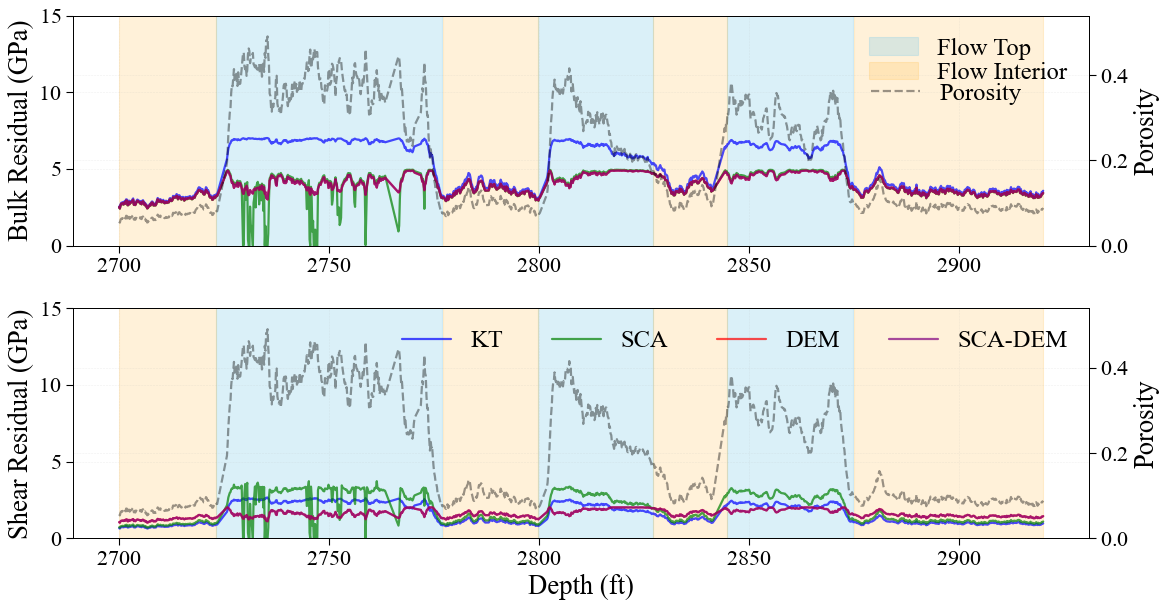

In [38]:
# Depth ranges for flow top and flow interior
flow_top_depths = [(2723.1, 2776.9), (2799.8, 2827.1), (2844.8, 2875)]
flow_interior_depths = [(2700, 2723.1), (2776.9, 2799.8), (2827.1, 2844.8), (2875, 2940)]


plt.figure(figsize=(15, 8))

# Plot Bulk residuals  (first subplot)
ax1 = plt.subplot(2, 1, 1)

# Mask and fill the regions for flow top and flow interior
for start, end in flow_top_depths:
    mask = (df['DEPTH'] >= start) & (df['DEPTH'] <= end)
    ax1.fill_between(df['DEPTH'], 0, 15 * 1.1, where=mask, color='skyblue', alpha=0.3,
                     label='Flow Top' if start == flow_top_depths[0][0] else "")

for start, end in flow_interior_depths:
    mask = (df['DEPTH'] >= start) & (df['DEPTH'] <= end)
    ax1.fill_between(df['DEPTH'], 0, 15 * 1.1, where=mask, color='orange', alpha=0.15,
                     label='Flow Interior' if start == flow_interior_depths[0][0] else "")

# Plot residuals
ax1.plot(df['DEPTH'], residual_KT_K_035_025, color='blue', alpha=0.7)
ax1.plot(df['DEPTH'], residual_SCA_K_035_025, color='green', alpha=0.7)
ax1.plot(df['DEPTH'], residual_DEM_K_035_025, color='red', alpha=0.7)
ax1.plot(df['DEPTH'], residual_SCA_DEM_K_035_025, color='purple', alpha=0.7)

ax1.set_ylabel("Bulk Residual (GPa)", fontsize=24)
ax1.set_ylim(0, 15)
ax1.tick_params(axis='both', labelsize=20)

# Add a secondary y-axis for Phi
ax1_phi = ax1.twinx()
phi_line_1, = ax1_phi.plot(df['DEPTH'], df['Phi'], linestyle='--', color='black', alpha=0.4, label='Porosity')
ax1_phi.set_ylabel("Porosity", fontsize=24, color='black')
ax1_phi.tick_params(axis='y', labelsize=20, colors='black')
ax1_phi.set_ylim(0, df['Phi'].max() * 1.1)

# Add legend for flow zones
ax1.legend(loc='upper right', fontsize=22)

# Plot Shear residuals (second subplot)
ax2 = plt.subplot(2, 1, 2)

# Mask and fill the regions for flow top and flow interior
for start, end in flow_top_depths:
    mask = (df['DEPTH'] >= start) & (df['DEPTH'] <= end)
    ax2.fill_between(df['DEPTH'], 0, 15 * 1.1, where=mask, color='skyblue', alpha=0.3)

for start, end in flow_interior_depths:
    mask = (df['DEPTH'] >= start) & (df['DEPTH'] <= end)
    ax2.fill_between(df['DEPTH'], 0, 15 * 1.1, where=mask, color='orange', alpha=0.15)

# Plot residuals
line_KT_shear = ax2.plot(df['DEPTH'], residual_KT_G_035_025, color='blue', label='KT', alpha=0.7)
line_SCA_shear = ax2.plot(df['DEPTH'], residual_SCA_G_035_025, color='green', label='SCA', alpha=0.7)
line_DEM_shear = ax2.plot(df['DEPTH'], residual_DEM_G_035_025, color='red', label='DEM', alpha=0.7)
line_SCA_DEM_shear = ax2.plot(df['DEPTH'], residual_SCA_DEM_G_035_025, color='purple', label='SCA-DEM', alpha=0.7)

ax2.set_xlabel("Depth (ft)", fontsize=24)
ax2.set_ylabel("Shear Residual (GPa)", fontsize=24)
ax2.set_ylim(0, 15)
ax2.tick_params(axis='both', labelsize=20)

# Add a secondary y-axis for Phi
ax2_phi = ax2.twinx()
phi_line_2, = ax2_phi.plot(df['DEPTH'], df['Phi'], linestyle='--', color='black', alpha=0.4, label='Porosity')
ax2_phi.set_ylabel("Porosity", fontsize=24, color='black')
ax2_phi.tick_params(axis='y', labelsize=20, colors='black')
ax2_phi.set_ylim(0, df['Phi'].max() * 1.1)

# Add legend for residuals
ax2.legend(loc='upper right', fontsize=22, ncol=4)

# Add a separate legend for Porosity
plt.gcf().legend(handles=[phi_line_1], loc='upper center', bbox_to_anchor=(0.802, 0.88), fontsize=22)
plt.tight_layout()
plt.show()


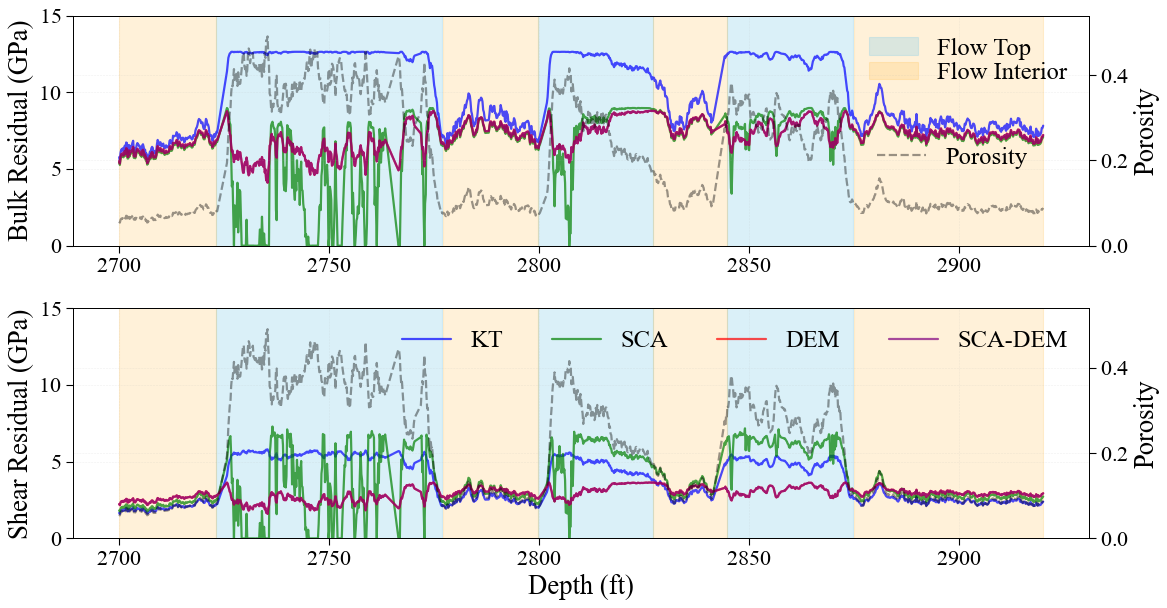

In [39]:
# Depth ranges for flow top and flow interior
flow_top_depths = [(2723.1, 2776.9), (2799.8, 2827.1), (2844.8, 2875)]
flow_interior_depths = [(2700, 2723.1), (2776.9, 2799.8), (2827.1, 2844.8), (2875, 2940)]

# Create a figure
plt.figure(figsize=(15, 8))

# Plot Bulk residuals (first subplot)
ax1 = plt.subplot(2, 1, 1)

# Mask and fill the regions for flow top and flow interior
for start, end in flow_top_depths:
    mask = (df['DEPTH'] >= start) & (df['DEPTH'] <= end)
    ax1.fill_between(df['DEPTH'], 0, 15 * 1.1, where=mask, color='skyblue', alpha=0.3,
                     label='Flow Top' if start == flow_top_depths[0][0] else "")

for start, end in flow_interior_depths:
    mask = (df['DEPTH'] >= start) & (df['DEPTH'] <= end)
    ax1.fill_between(df['DEPTH'], 0, 15 * 1.1, where=mask, color='orange', alpha=0.15,
                     label='Flow Interior' if start == flow_interior_depths[0][0] else "")

# Plot residuals
ax1.plot(df['DEPTH'], residual_KT_K_025_015, color='blue', alpha=0.7)
ax1.plot(df['DEPTH'], residual_SCA_K_025_015, color='green', alpha=0.7)
ax1.plot(df['DEPTH'], residual_DEM_K_025_015, color='red', alpha=0.7)
ax1.plot(df['DEPTH'], residual_SCA_DEM_K_025_015, color='purple', alpha=0.7)

ax1.set_ylabel("Bulk Residual (GPa)", fontsize=24)
ax1.set_ylim(0, 15)
ax1.tick_params(axis='both', labelsize=20)

# Add a secondary y-axis for Phi
ax1_phi = ax1.twinx()
phi_line_1, = ax1_phi.plot(df['DEPTH'], df['Phi'], linestyle='--', color='black', alpha=0.4, label='Porosity')
ax1_phi.set_ylabel("Porosity", fontsize=24, color='black')
ax1_phi.tick_params(axis='y', labelsize=20, colors='black')
ax1_phi.set_ylim(0, df['Phi'].max() * 1.1)

# Add legend for flow zones
ax1.legend(loc='upper right', fontsize=22)

# Plot Shear residuals (second subplot)
ax2 = plt.subplot(2, 1, 2)

# Mask and fill the regions for flow top and flow interior
for start, end in flow_top_depths:
    mask = (df['DEPTH'] >= start) & (df['DEPTH'] <= end)
    ax2.fill_between(df['DEPTH'], 0, 15 * 1.1, where=mask, color='skyblue', alpha=0.3)

for start, end in flow_interior_depths:
    mask = (df['DEPTH'] >= start) & (df['DEPTH'] <= end)
    ax2.fill_between(df['DEPTH'], 0, 15 * 1.1, where=mask, color='orange', alpha=0.15)

# Plot residuals
line_KT_shear = ax2.plot(df['DEPTH'], residual_KT_G_025_015, color='blue', label='KT', alpha=0.7)
line_SCA_shear = ax2.plot(df['DEPTH'], residual_SCA_G_025_015, color='green', label='SCA', alpha=0.7)
line_DEM_shear = ax2.plot(df['DEPTH'], residual_DEM_G_025_015, color='red', label='DEM', alpha=0.7)
line_SCA_DEM_shear = ax2.plot(df['DEPTH'], residual_SCA_DEM_G_025_015, color='purple', label='SCA-DEM', alpha=0.7)

ax2.set_xlabel("Depth (ft)", fontsize=24)
ax2.set_ylabel("Shear Residual (GPa)", fontsize=24)
ax2.set_ylim(0, 15)
ax2.tick_params(axis='both', labelsize=20)

# Add a secondary y-axis for Phi
ax2_phi = ax2.twinx()
phi_line_2, = ax2_phi.plot(df['DEPTH'], df['Phi'], linestyle='--', color='black', alpha=0.4, label='Porosity')
ax2_phi.set_ylabel("Porosity", fontsize=24, color='black')
ax2_phi.tick_params(axis='y', labelsize=20, colors='black')
ax2_phi.set_ylim(0, df['Phi'].max() * 1.1)

# Add legend for residuals
ax2.legend(loc='upper right', fontsize=22, ncol=4)

# Add a separate legend for Porosity
plt.gcf().legend(handles=[phi_line_1], loc='upper center', bbox_to_anchor=(0.807, 0.78), fontsize=22)
plt.tight_layout()
plt.show()
